<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_6.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(robust-reg-notebook)=
# Regressione robusta

In un mondo in cui i dati anomali sono comuni e possono portare a interpretazioni errate, la regressione robusta bayesiana emerge come una soluzione molto utile. Questo capitolo esplorerà gli aspetti chiave di questa metodologia, dalla comprensione degli outliers all'utilizzo di tecniche come la distribuzione Student-t e Pareto Smoothed Importance Sampling (PSIS) per affrontare le sfide poste da dati anomali e modelli complessi, fornendo una guida pratica e teorica per la moderna analisi statistica.

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
from sklearn.preprocessing import scale
from scipy import stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Osservazioni anomale e influenti

Le osservazioni anomale, meglio note come outlier, che si posizionano agli estremi della distribuzione predittiva, rivestono un ruolo cruciale nell'analisi dati e nella costruzione di modelli statistici. L'emergenza di tali osservazioni può indicare un'eccessiva fiducia nelle stime del modello, rendendone le previsioni potenzialmente inattendibili. In altre parole, la presenza di outlier mette in luce l'incapacità del modello di rappresentare adeguatamente la variabilità dei dati, suggerendo che il modello stesso potrebbe essere inadeguato o mal configurato.

Non è consigliabile ignorare gli outlier. Rimuoverli senza un'analisi approfondita della loro provenienza e natura potrebbe portare a conclusioni imprecise. Si tratta, infatti, di un tentativo di "correggere" i dati piuttosto che migliorare il modello, una strategia che rischia di occultare i problemi sottostanti invece di affrontarli.

La vera sfida sta nel comprendere come e perché gli outlier incidono sul modello e nel cercare metodi per incorporare, piuttosto che escludere, queste informazioni. Questo comporta una rigorosa quantificazione dell'effetto di ciascuna osservazione anomala, trattando gli outlier come una componente informativa nell'analisi complessiva.

Per affrontare efficacemente questo problema, è possibile adottare approcci statistici robusti. Questi possono variare dalla revisione della funzione di verosimiglianza, per renderla più tollerante a fluttuazioni estreme, all'adozione di distribuzioni a priori che considerino la possibilità di deviazioni, fino all'uso di tecniche specializzate per l'identificazione e lo studio degli outlier.

In conclusione, gli outlier non devono essere percepiti come un ostacolo, ma come un'opportunità per raffinare e migliorare il modello statistico. L'omissione o l'eliminazione precipitosa degli outlier può portare a interpretazioni erronee e a previsioni inaffidabili. Al contrario, un'analisi accurata e un'integrazione metodica degli outlier possono migliorare la comprensione del fenomeno in esame e rendere le previsioni più precise e attendibili.

## Mistura di Gaussiane 

La distribuzione t di Student, comunemente usata in statistica, può essere intuitivamente compresa come il risultato della combinazione di diverse distribuzioni gaussiane (normali) con varianze diverse. 

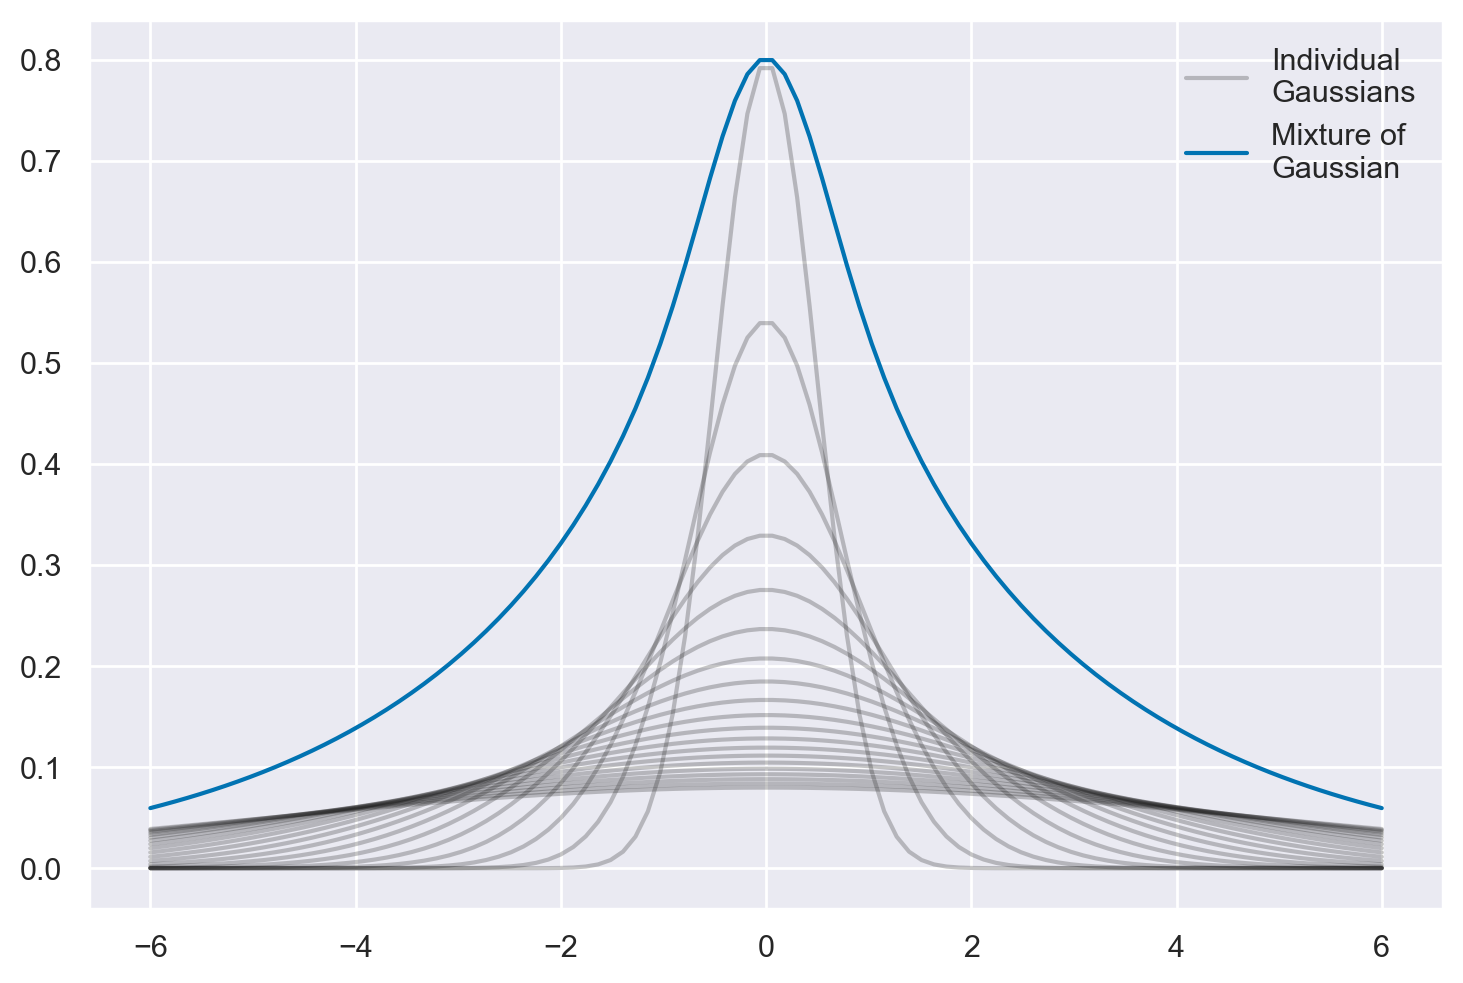

In [3]:
# Creazione dell'array di valori x
xs = np.linspace(-6, 6, 100)

# Inizializzazione dell'array per i PDF (Probability Density Function)
pdfs = []

# Numero di gaussiane
n_gaussians = 20

# Ciclo per tracciare ogni gaussiana
for variance in np.linspace(.5, 5, n_gaussians):
    label = "Individual\nGaussians" if variance == .5 else None
    pdf = stats.norm(0, variance).pdf(xs)
    pdfs.append(pdf)
    plt.plot(xs, pdf, color='k', label=label, alpha=.25)  # Usa matplotlib.pyplot.plot

# Calcolo della somma dei PDFs
sum_of_pdfs = np.array(pdfs).sum(axis=0)
sum_of_pdfs /= sum_of_pdfs.max()
sum_of_pdfs *= (1 - n_gaussians / 100)

# Tracciare la somma dei PDFs
plt.plot(xs, sum_of_pdfs, color='C0', label='Mixture of\nGaussian')

# Aggiungere la legenda
plt.legend()

# Mostrare il grafico
plt.show()

Questa caratteristica ha implicazioni significative per l'analisi statistica, soprattutto in ambiti come la psicologia dove la variabilità e gli outliers sono frequenti. 

1. **Code più Pesanti della Distribuzione t di Student**:
   - La somma di distribuzioni gaussiane con varianze diverse porta alla formazione di una distribuzione con code più pesanti rispetto a una singola distribuzione gaussiana. Questo significa che, rispetto a una normale gaussiana, la distribuzione t di Student presenta una maggior frequenza di osservazioni estreme.
   - Queste code più pesanti rendono la distribuzione t di Student particolarmente adatta per modellare dati che non aderiscono strettamente a una distribuzione normale, soprattutto in presenza di outliers. È quindi un modello utile quando si analizzano dati che si discostano dai presupposti della normalità.

2. **Cattura Implicita dell'Eterogeneità Non Osservata**:
   - Spesso, nei dati psicologici e in altri campi, si incontrano dati che provengono da popolazioni eterogenee, caratterizzate da differenze sottili e non sempre osservabili direttamente. Queste differenze possono derivare da una varietà di processi sottostanti con varianze diverse.
   - La distribuzione t di Student, essendo una miscela di gaussiane, è capace di modellare efficacemente questa eterogeneità intrinseca. Ogni componente gaussiana nella mistura può rappresentare un processo sottostante diverso, e la combinazione di queste componenti descrive la variabilità complessiva dei dati.

3. **Minore Sensibilità agli Outliers**:
   - Un'importante caratteristica della distribuzione t di Student è la sua minore sensibilità agli outliers rispetto alla distribuzione gaussiana. Le sue code più pesanti conferiscono maggiore probabilità alle osservazioni estreme, rendendola più tollerante nei confronti di questi valori anomali.
   - Nei modelli bayesiani, l'utilizzo di una distribuzione a posteriori t di Student può essere preferibile in presenza di dati contaminati da outliers. Questo perché la distribuzione t di Student fornisce stime più robuste, riducendo l'impatto distortivo degli outliers sulle conclusioni del modello.

In sintesi, la distribuzione t di Student, con le sue code più pesanti e la sua capacità di modellare eterogeneità e tollerare outliers, si rivela un'opzione potente e flessibile per l'analisi statistica, specialmente in contesti complessi e variabili come quelli incontrati nella ricerca psicologica.

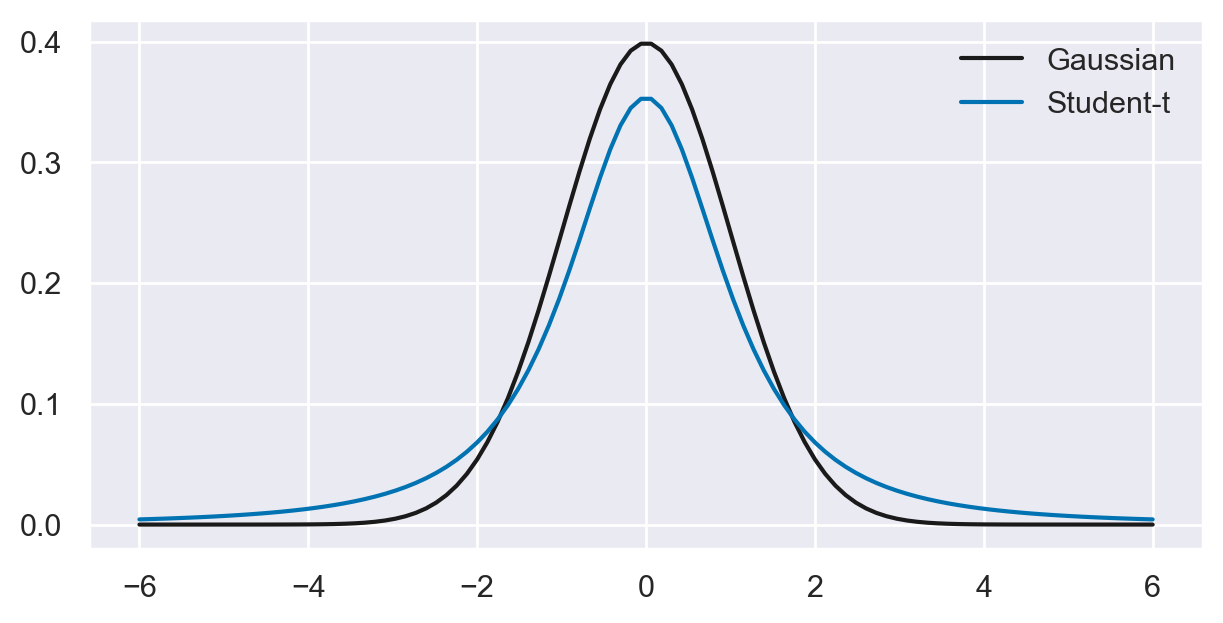

In [4]:
# Creazione dell'array di valori x
xs = np.linspace(-6, 6, 100)

# Configurazione delle dimensioni del grafico
plt.subplots(figsize=(6, 3))

# Tracciare la distribuzione normale (Gaussiana)
plt.plot(xs, stats.norm.pdf(xs), color='k', label='Gaussian')

# Tracciare la distribuzione Student-t
plt.plot(xs, stats.t(2).pdf(xs), color='C0', label='Student-t')

# Aggiungere la legenda
plt.legend()

# Mostrare il grafico
plt.show()


## Un esempio concreto

In questo capitolo considereremo il dataset `WaffleDivorce`. Questo dataset contiene i tassi di divorzio in ciascuno dei 50 stati degli USA, insieme a predittori come la popolazione, l'età media del matrimonio, se si tratta di uno stato del Sud e, curiosamente, il numero di Waffle Houses.

Iniziamo importando i dati. 

In [5]:
divorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


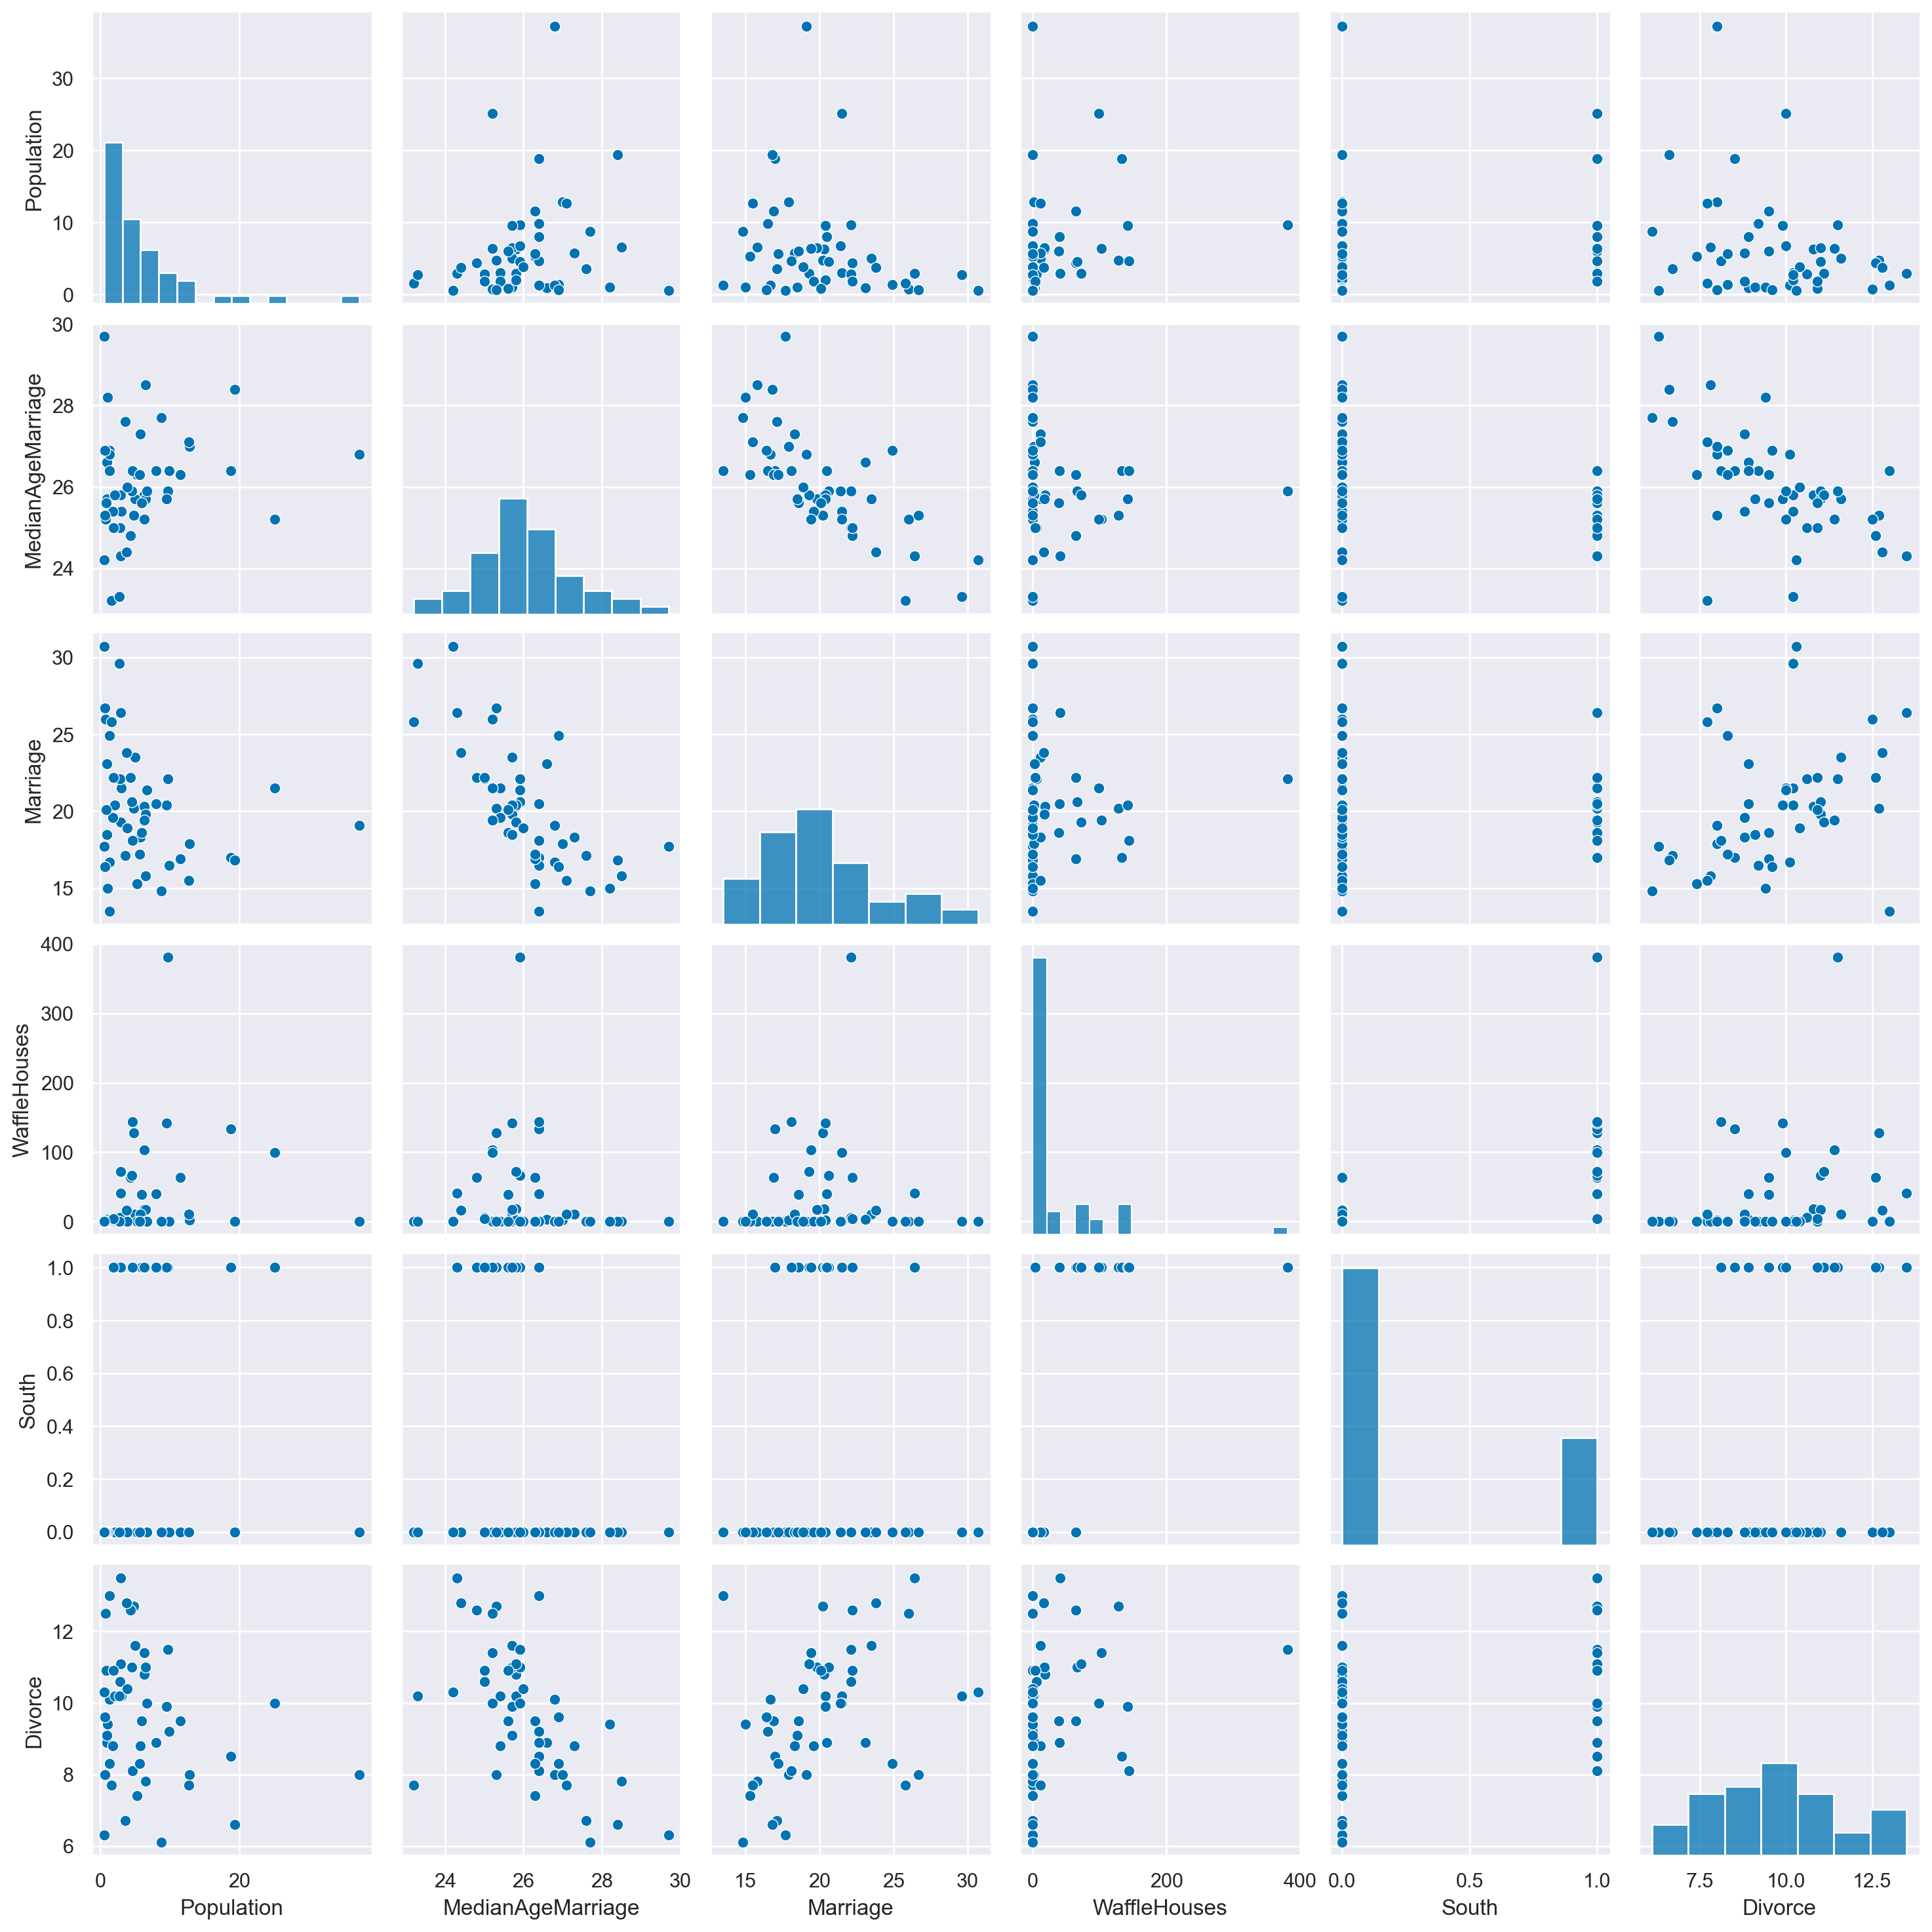

In [6]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(divorce, x_vars=vars, y_vars=vars);

Ci porremo il problema di predire il tasso di divorzio negli stati del sud mediante il tasso di matrimonio e l'età media del matrimonio.

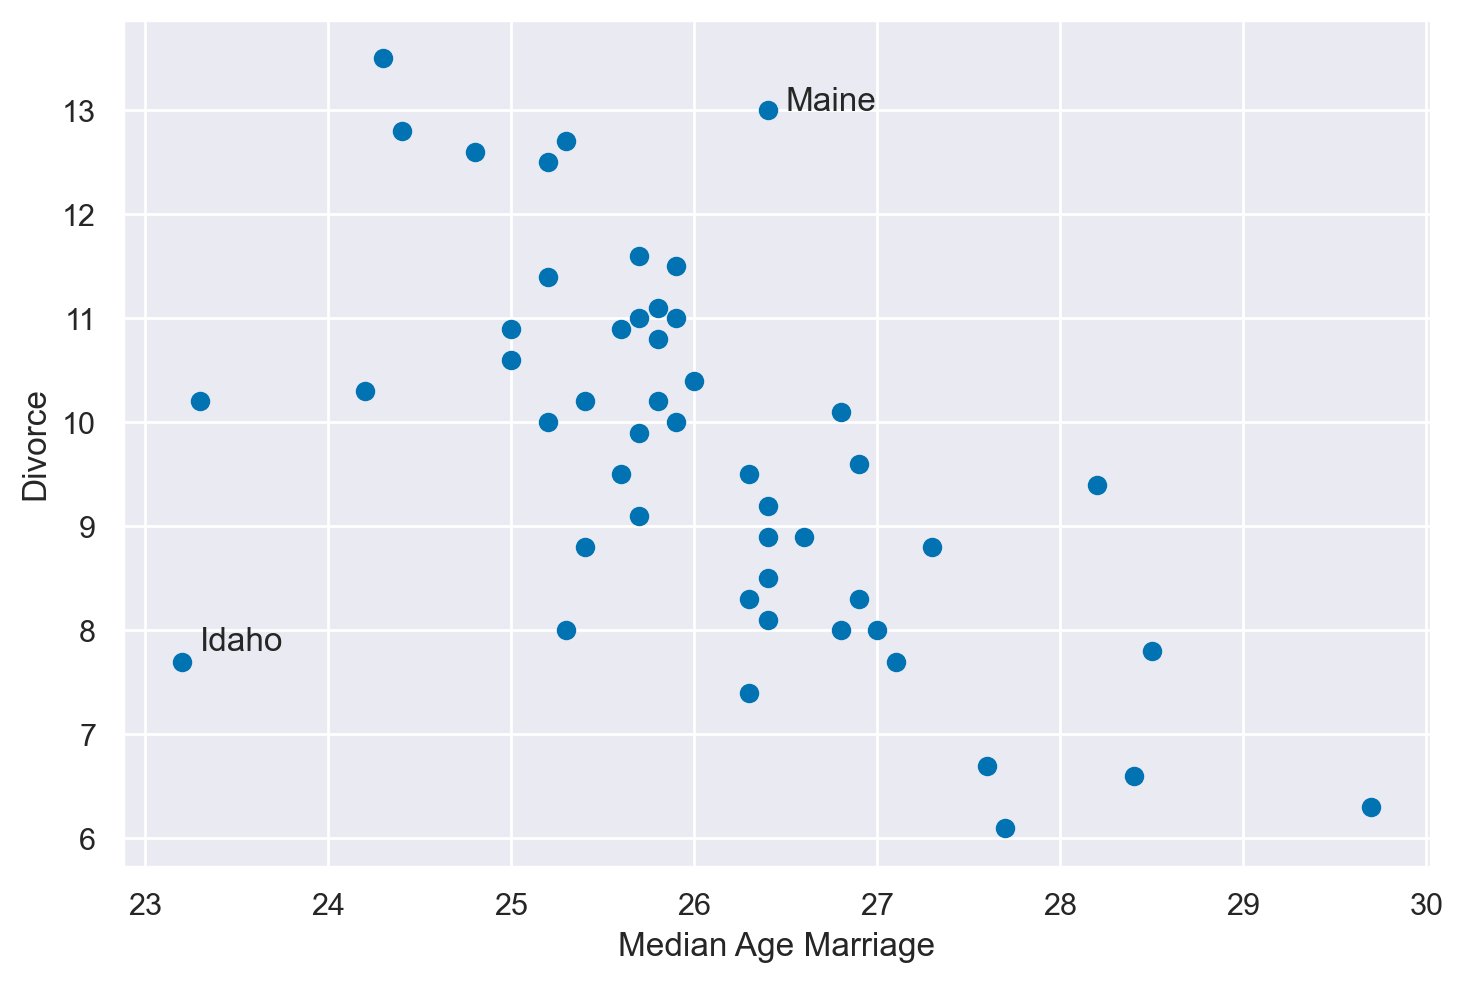

In [7]:
plt.scatter(divorce["MedianAgeMarriage"], divorce["Divorce"])

# Annotare il punto (26.5, 13) con 'Maine'
plt.annotate('Maine', xy=(26.5, 13), xytext=(26.5, 13))
# Annotare il punto (23.3, 7.8) con 'Idaho'
plt.annotate('Idaho', xy=(23.3, 7.8), xytext=(23.3, 7.8))

plt.xlabel("Median Age Marriage")
plt.ylabel("Divorce")
plt.show()

Si noti che Maine e Idaho presentano entrambi caratteristiche inusuali relativamente alla relazione tra divorzio e età media del matrimonio: il Maine mostra un tasso di divorzio insolitamente alto rispetto alla tendenza generale, mentre l'Idaho ha un tasso di divorzio insolitamente basso.

Queste anomalie possono essere esaminate in modo rigoroso attraverso l'utilizzo di metodi statistici avanzati. Un modo principale per quantificare questi outlier è attraverso l'utilizzo della statistica PSIS $k$, una tecnica che può aiutare a determinare l'effetto delle osservazioni estreme su una distribuzione.

Un'altra considerazione importante nel contesto di questi Stati è l'ipotesi che la popolazione sia il risultato di una miscela di distribuzioni gaussiane. Questo approccio, noto come "Mixing Gaussians," assume che vi siano sottogruppi all'interno della popolazione che seguono diverse distribuzioni gaussiane.

Quando si mescolano distribuzioni gaussiane con la stessa media ma varianze diverse, si ottengono code più spesse. Questo fenomeno porta alla distribuzione Student-t, che è particolarmente utile nell'analisi di dati con code pesanti.

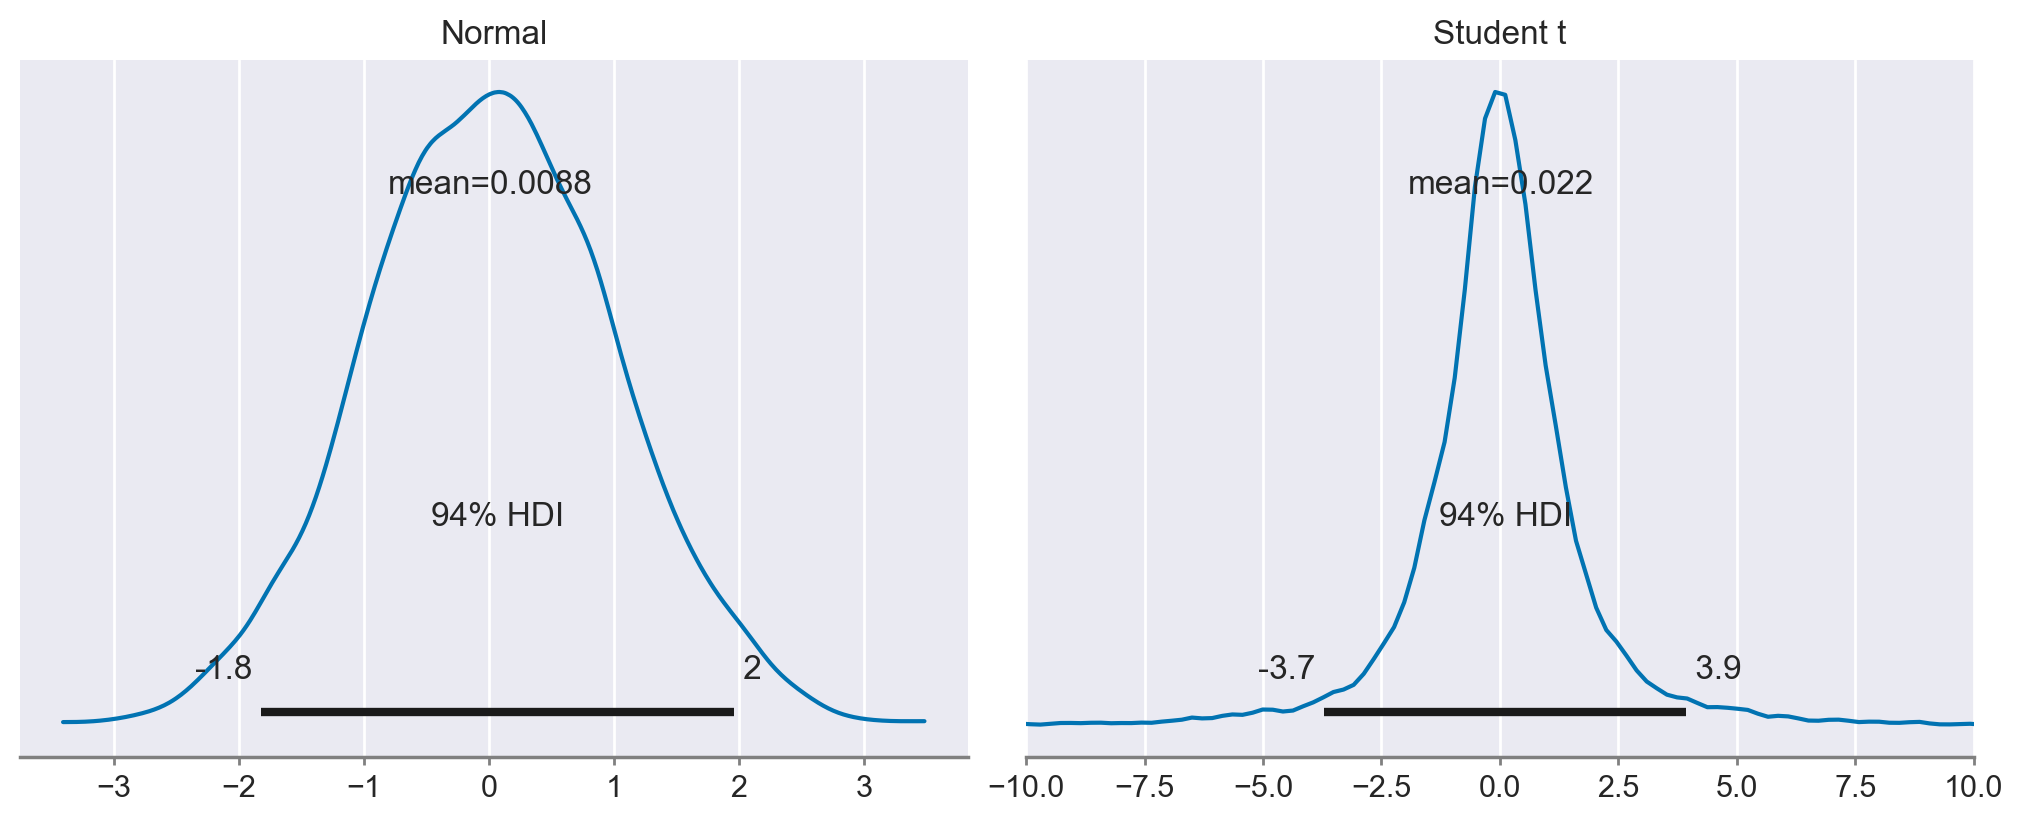

In [8]:
az.plot_posterior(
    {
        "Normal": np.random.normal(size=10000),
        "Student t": np.random.standard_t(df=2, size=10000),
    },
    figsize=(10, 4)
)
plt.xlim(-10, 10);

Nell'ambito della statistica, la distribuzione gaussiana e la distribuzione Student-t sono due strumenti fondamentali utilizzati per modellare i dati. Tuttavia, presentano differenze significative nella loro reazione agli outlier.

La distribuzione gaussiana è spesso descritta come molto scettica riguardo a qualsiasi valore che si trova al di fuori di poche deviazioni standard dalla media. In altre parole, gli outlier sono considerati altamente improbabili in una distribuzione normale e possono avere un impatto notevole sull'analisi, spesso portando a conclusioni errate se non trattati correttamente.

D'altra parte, la distribuzione Student-t è molto meno disturbata dagli outlier e mostra un minor scetticismo nei loro confronti. Questo è dovuto alla forma delle sue code, che sono più pesanti rispetto a quelle della distribuzione gaussiana. Di conseguenza, la distribuzione Student-t assegna una probabilità maggiore agli outlier, rendendola più robusta in presenza di valori anomali.

Questa differenza nelle reazioni agli outlier può avere implicazioni importanti nella scelta del modello più appropriato per un dato set di dati. Se i dati contengono molti outlier, o se c'è una ragione per credere che gli outlier possano essere un fenomeno intrinseco e non un errore, allora la distribuzione Student-t potrebbe essere una scelta più appropriata. D'altro canto, se gli outlier sono rari e considerati non informativi, allora un approccio gaussiano potrebbe essere più adatto.

In sintesi, mentre la distribuzione gaussiana può essere sensibile agli outlier, considerandoli come eventi rari e quindi potenzialmente problematici, la distribuzione Student-t è meno perturbata da questi valori estremi. La scelta tra queste due distribuzioni dovrebbe quindi essere guidata dalla natura dei dati e dall'importanza attribuita agli outlier nell'analisi.

Prima di tutto, notiamo che le nostre variabili predittive hanno scale leggermente diverse. È una buona pratica standardizzare le nostre variabili predittive e di risposta in modo che abbiano una media di 0 e una deviazione standard di 1.

In [9]:
A = scale(divorce["MedianAgeMarriage"])
D = scale(divorce["Divorce"]) # tasso di divorzio
M = scale(divorce["Marriage"]) # tasso di matrimonio

Implementiamo un modello di regressione lineare per analizzare la relazione tra il tasso di divorzio (variabile dipendente) e le variabili indipendenti, che sono l'età media al matrimonio e il tasso di matrimonio. In questa analisi iniziale, l'ipotesi sottostante è che gli errori, o residui, seguano una distribuzione normale (gaussiana). 

In [10]:
with pm.Model() as n_model:
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    mu = a + bM * M + bA * A
    Dmod = pm.Normal("D", mu, sigma, observed=D)
    
    n_sample = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:01.104251


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1400.11it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1401.19it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1402.67it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1404.03it/s]


Sampling time = 0:00:01.656548


Transforming variables...


Transformation time = 0:00:00.073145


Computing Log Likelihood...


Log Likelihood time = 0:00:00.126190


Si noti che l'argomento `idata_kwargs={"log_likelihood": True}` passato alla funzione `sample_numpyro_nuts` è usato per specificare le opzioni per la creazione dell'oggetto `InferenceData` che sarà restituito. In questo caso, stiamo indicando che vogliamo che il logaritmo della verosimiglianza sia incluso nell'oggetto `InferenceData`. Il logaritmo della verosimiglianza può essere utilizzato per ulteriori analisi e diagnostica, come il calcolo del LOO (Leave-One-Out Cross-Validation).

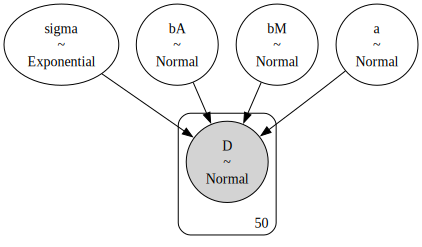

In [11]:
pm.model_to_graphviz(n_model)

In un secondo modello assumiamo che gli errori seguano una distribuzione $t$ di Student con 2 gradi di libertà.

In [12]:
with pm.Model() as t_model:
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    mu = a + bM * M + bA * A
    Dmod = pm.StudentT("D", mu=mu, sigma=sigma, nu=2, observed=D)

    t_sample = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.867863


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1378.68it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1379.67it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1380.81it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1381.88it/s]


Sampling time = 0:00:01.543389


Transforming variables...


Transformation time = 0:00:00.044692


Computing Log Likelihood...


Log Likelihood time = 0:00:00.166122


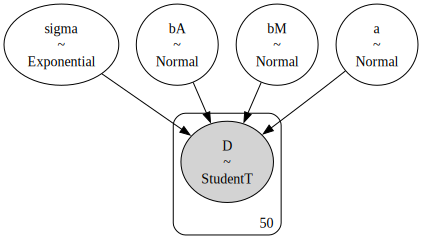

In [13]:
pm.model_to_graphviz(t_model)

Il modello che assume una distribuzione gaussiana dei residui produce una stima a posteriori della pendenza della retta di regressione che è maggiore rispetto a quella ottenuta mediante un modello che assume una distribuzione $t$ di Student per gli errori.

```{note}
:class: dropdown
Si tenga presente che, in questo contesto, abbiamo adottato un modello che presuppone una distribuzione $ t $ di Student con $\nu = 2$ gradi di libertà. Questa specifica scelta di $\nu$ corrisponde a una distribuzione $ t $ di Student caratterizzata da code particolarmente pesanti. Generalmente, il parametro $\nu$ può essere stimato direttamente dal modello stesso. Per un esempio pratico di questo approccio, si faccia riferimento al [case study](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html) disponibile sul sito di [PyMC](https://www.pymc.io/welcome.html).
```

In [14]:
az.summary(n_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.607,0.159,-0.921,-0.322,0.003,0.002,3103.0,2762.0,1.0
bM,-0.060,0.160,-0.361,0.233,0.003,0.002,3136.0,2691.0,1.0
a,-0.001,0.117,-0.231,0.211,0.002,0.002,3521.0,2579.0,1.0
sigma,0.838,0.089,0.677,1.002,0.002,0.001,3151.0,2864.0,1.0


In [15]:
az.summary(t_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.691,0.144,-0.967,-0.423,0.002,0.002,3409.0,2894.0,1.0
bM,0.050,0.200,-0.324,0.425,0.003,0.003,3475.0,3120.0,1.0
a,0.027,0.110,-0.171,0.238,0.002,0.002,4341.0,2970.0,1.0
sigma,0.586,0.088,0.424,0.752,0.001,0.001,3967.0,3123.0,1.0


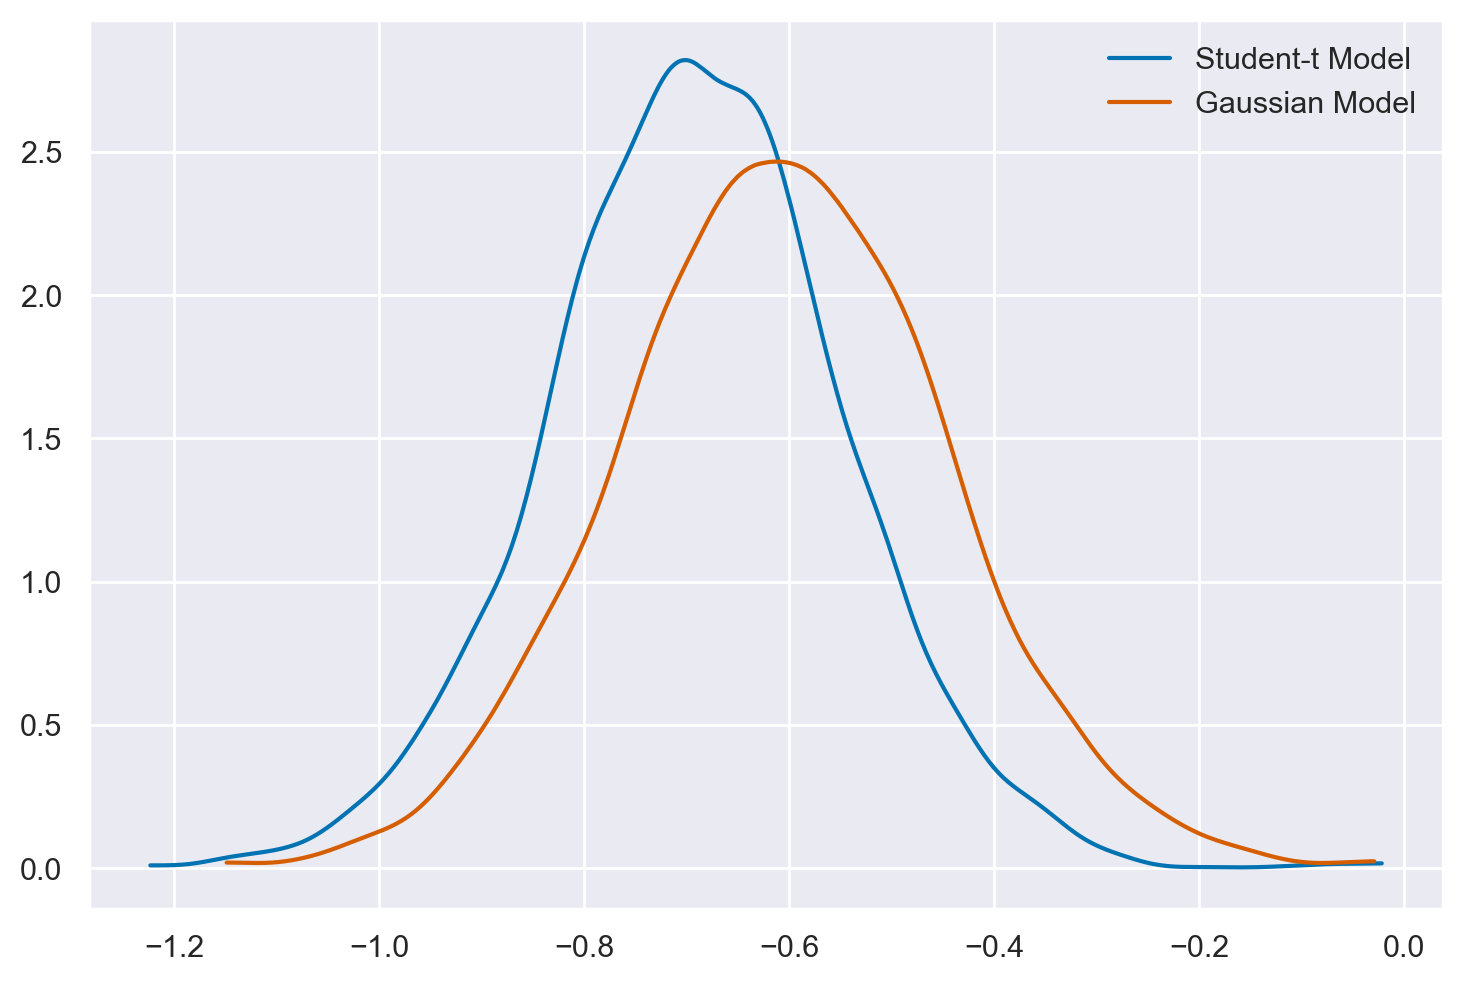

In [16]:
az.plot_dist(t_sample.posterior["bA"], color="C0", label="Student-t Model")
az.plot_dist(n_sample.posterior["bA"], color="C3", label="Gaussian Model");


I valori anomali hanno l'effetto di "spingere" il posteriore verso lo zero nella regressione lineare gaussiana classica. Invece, il modello student-t è più robusto e meno influenzato da questi valori anomali.

Si noti inoltre che, quando si sono presentati dati anomali, l'impiego della distribuzione $t$ di Student ha portato a un adattamento del modello più accurato, come evidenziato dai valori diagnostici Pareto $k$.

In [17]:
az.loo(n_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -64.71     6.45
p_loo        5.09        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   98.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    2.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
az.loo(t_sample)

Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -67.07     5.70
p_loo        6.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Nelle figure successive mettiamo in relazione i valori diagnostici Pareto $k$ con il *Watanabe-Akaike Information Criterion* (WAIC). Il WAIC è una misura usata per valutare la qualità di un modello statistico. Simile al più familiare criterio di informazione di Akaike (AIC) utilizzato in contesti frequentisti, il WAIC si propone di quantificare la bontà di adattamento di un modello ai dati, tenendo conto anche della complessità del modello stesso. L'obiettivo è evitare sia il sovradimensionamento ("overfitting") che il sotto-dimensionamento ("underfitting") del modello. In termini semplici, il WAIC misura quanto bene un modello probabilistico predice nuovi dati.

Il WAIC funziona calcolando la log-verosimiglianza dei dati, corretta per il numero effettivo di parametri nel modello. Un valore più basso di WAIC indica un modello con una migliore performance previsionale.

Il PSIS (*Pareto Smoothed Importance Sampling*) Pareto $k$ misura la qualità dell'approssimazione utilizzata nel calcolare il WAIC. Quando si calcola il WAIC, si utilizza spesso l'importance sampling, un metodo per stimare proprietà di una distribuzione di probabilità mentre si campionano da una distribuzione diversa. Il PSIS è una versione migliorata di questo metodo. Il valore di Pareto $k$ è un indicatore di quanto bene funziona l'importance sampling per un dato modello e un dato set di dati. Valori alti di Pareto $k$ (tipicamente maggiori di 0.7) indicano che l'approssimazione potrebbe non essere affidabile, suggerendo che le stime di WAIC potrebbero essere distorte. In altre parole, un alto valore di Pareto $k$ indica che il modello potrebbe avere problemi nel predire determinate osservazioni nei dati, spesso a causa di outliers o di una cattiva adattabilità del modello.

Mettere in relazione WAIC e PSIS Pareto $k$ è utile perché fornisce una visione più completa della performance di un modello. Il WAIC da solo fornisce una misura di quanto bene il modello si adatta ai dati e gestisce la complessità, ma non fornisce informazioni sulla qualità dell'approssimazione usata per calcolarlo. Il valore di Pareto $k$, d'altra parte, aiuta a valutare l'affidabilità di questa approssimazione, offrendo quindi una visione più completa e affidabile della qualità del modello.

Nella seguente funzione, il WAIC viene calcolato in modo puntiforme (`pointwise=True`), il che significa che viene calcolato separatamente per ogni singola osservazione nel set di dati. Il calcolo puntuale del WAIC consente di esaminare come ciascun punto di dati contribuisca al valore complessivo del WAIC e di identificare potenziali outlier o punti problematici nel modello. Questo è differente dal calcolare un singolo WAIC per l'intero modello.

In [19]:
def plot_loocv(inference, title=None, outliers_idx=[], divorce=None):
    plt.subplots(figsize=(6,3))
    pareto_k = az.loo(inference, pointwise=True).pareto_k
    waic = -az.waic(inference, pointwise=True).waic_i

    plt.scatter(pareto_k, waic, color='C0', label=None)

    # Assicurati che outliers_idx e divorce siano definiti
    for oi in outliers_idx:
        if divorce is not None and oi in divorce.index:
            plt.annotate(divorce.loc[oi, "Location"], (pareto_k[oi] + .01, waic[oi]), fontsize=14)

    plt.xlabel("PSIS Pareto K")
    plt.ylabel("WAIC")
    plt.title(title)
    plt.show()

Possiamo dunque creare un grafico che mostra i valori di WAIC in funzione dei valori Pareto $k$. Con questa rappresentazione possiamo esaminare come ogni osservazione influisca sulla performance del modello e sulla sua affidabilità. Se un punto ha un alto valore di Pareto $k$ e un elevato impatto negativo sul WAIC (indicato da un alto valore negativo di WAIC), potrebbe essere un candidato per un'ulteriore revisione o esclusione dal modello.

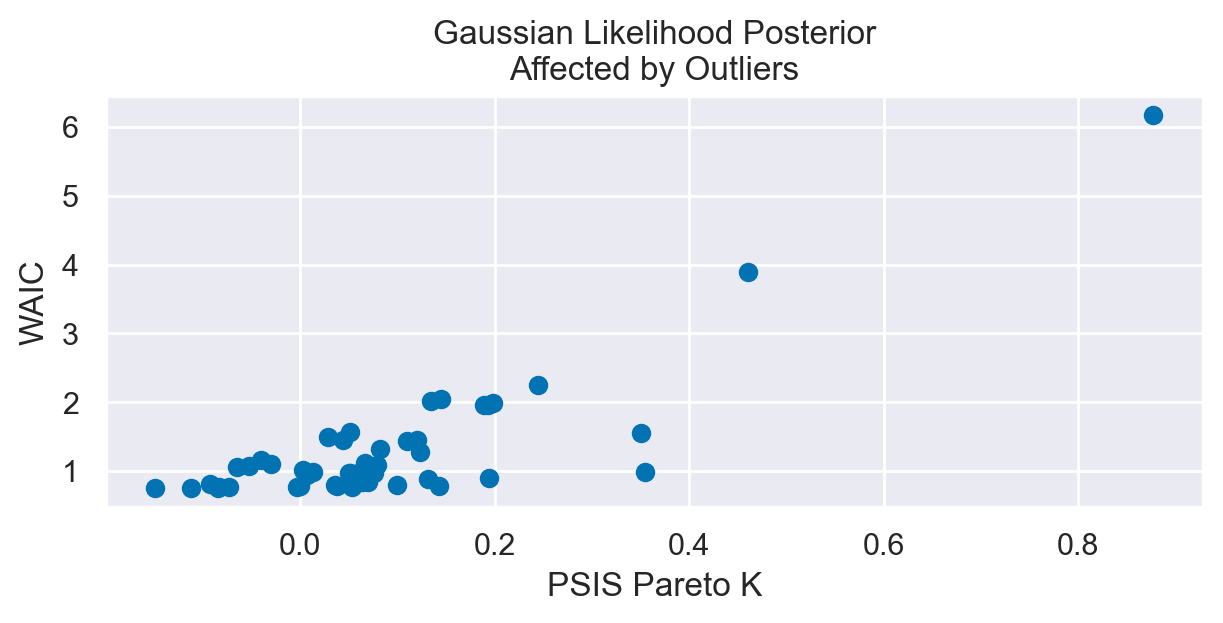

In [20]:
plot_loocv(n_sample, title="Gaussian Likelihood Posterior\nAffected by Outliers")

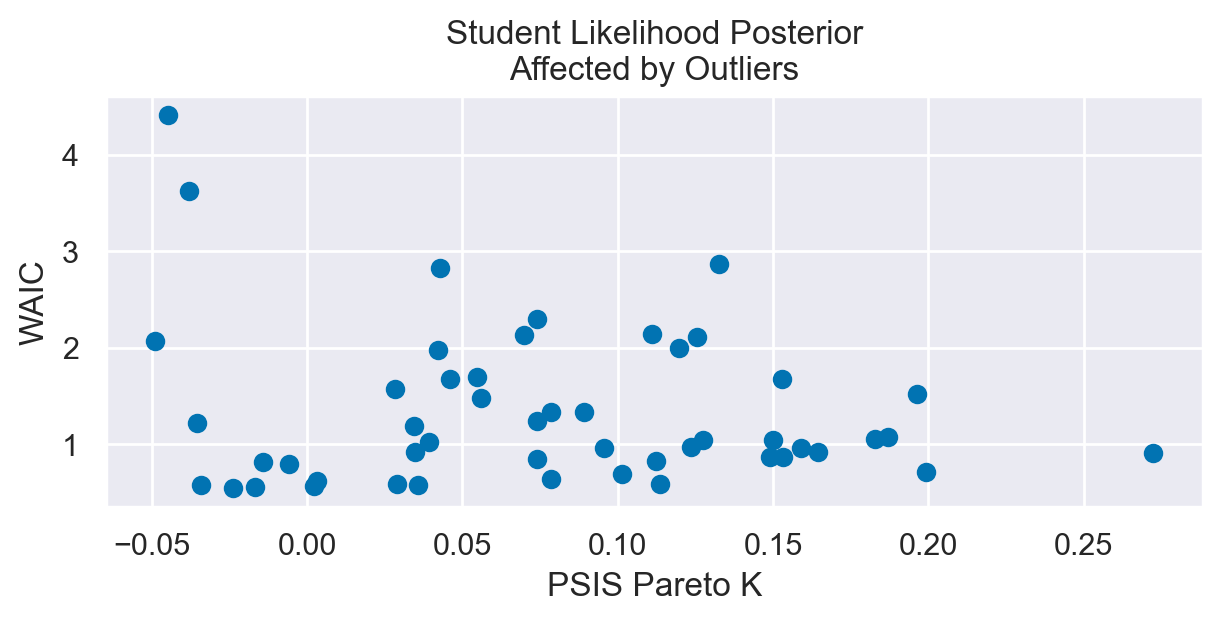

In [21]:
plot_loocv(t_sample, title="Student Likelihood Posterior\nAffected by Outliers")

È evidente che, per i dati in esame, quando si utilizza un modello di regressione lineare che assume una distribuzione degli errori t di Student, sia il WAIC che i valori diagnostici Pareto $k$ risultano essere inferiori. Questa riduzione indica una maggiore efficienza del modello nella previsione dei dati.

## Confronto tra Modelli

Eseguiamo ora un'analisi di validazione incrociata Leave-One-Out (LOO) per confrontare i due modelli statistici, il modello gaussiano e il modello basato sulla distribuzione t di Student.

In [22]:
comparison = az.compare(
    {
        "Gaussian Model": n_sample,
        "Student t Model": t_sample
    }, 
    scale='deviance'
)
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gaussian Model,0,129.421075,5.094203,0.000000,0.806862,12.908591,0.000000,True,deviance
Student t Model,1,134.132267,6.317006,4.711192,0.193138,11.406402,6.001906,False,deviance


Come abbiamo visto in precedenza, la ELPD (*Expected Log Predictive Density*) è una misura della performance predittiva di un modello statistico. Rappresenta il logaritmo della densità predittiva media attesa, calcolata attraverso la validazione incrociata LOO. Un valore più alto di ELPD indica una migliore capacità del modello di adattarsi ai dati e di fare previsioni accurate su nuovi dati non visti.

1. **Rank**: Indica la classificazione dei modelli in base alla loro performance. Un rank di 0 significa il modello migliore.

2. **elpd_loo**: È il valore di ELPD calcolato usando la validazione incrociata LOO. 
   - Per il Gaussian Model, l'elpd_loo è 129.138506.
   - Per il Student t Model, l'elpd_loo è 134.232129.

3. **p_loo**: Rappresenta la complessità effettiva del modello. Un valore più alto suggerisce un modello più complesso.

4. **elpd_diff**: Differenza di ELPD rispetto al modello migliore. Un valore più basso qui è migliore.

5. **weight**: I pesi dati ai modelli nel calcolo della media dell'ensemble.

6. **se**: Errore standard di elpd_loo.

7. **dse**: Differenza standard nell'errore tra i modelli.

8. **warning**: Indica se ci sono stati problemi nel calcolo del LOO per quel modello.

9. **scale**: La scala utilizzata per il calcolo, in questo caso la devianza.

- Guardando l'elpd_loo, il **Student t Model** ha un valore più alto (134.232129) rispetto al Gaussian Model (129.138506), indicando una migliore performance predittiva.
- Il "rank" conferma questa interpretazione, collocando il Gaussian Model a rank 0 (peggiore) e lo Student t Model a rank 1 (migliore).
- La differenza in ELPD (elpd_diff) di 5.093623 a favore dello Student t Model suggerisce che ha una capacità predittiva significativamente migliore rispetto al modello gaussiano.
- Anche se il modello t di Student ha una maggiore complessità (p_loo più alto), la sua migliore performance predittiva lo rende preferibile in questo caso.

In conclusione, basandoci sull'ELPD e altri parametri correlati, il modello basato sulla distribuzione t di Student risulta il modello migliore tra i due. Mostra una capacità predittiva superiore, come indicato dal suo più alto valore di ELPD e dal suo rank migliore. Questo dimostra che, nonostante una maggiore complessità, è in grado di adattarsi e prevedere i dati in modo più efficace rispetto al modello gaussiano.

## Commenti e considerazioni conclusive

Nella pratica statistica, si incontrano spesso situazioni in cui l'eterogeneità non osservata - variazioni o differenze tra osservazioni in un insieme di dati che non sono spiegabili attraverso le variabili misurabili nel contesto dello studio - svolge un ruolo significativo. Questa eterogeneità si manifesta quando le differenze osservate tra i dati non possono essere attribuite completamente alle variabili note e misurabili. Al contrario, esistono fattori ignoti o non misurati che influenzano le osservazioni, che possono essere intrinseci alle unità di osservazione o dipendere da condizioni ambientali o contestuali non contemplate durante la progettazione dello studio o la raccolta dei dati.

Per modellare questa eterogeneità, spesso si utilizzano miscele di distribuzioni gaussiane o Student-t. La scelta della distribuzione Student-t in particolare implica un modello che è meno sensibile agli effetti dei valori estremi, o "outliers", grazie alle sue code più pesanti. Tuttavia, una sfida nella modellazione statistica risiede nel corretto posizionamento dei parametri dei gradi di libertà della distribuzione Student-t, specialmente perché gli outliers sono eventi rari e quindi difficili da stimare accuratamente.

In assenza di una teoria solida per guidare la scelta del modello statistico, la regressione robusta, basata su una distribuzione Student-t, emerge come una strategia prudente. Questo approccio si contrappone alla metodologia gaussiana standard, che può risultare inadeguata nel gestire gli effetti dei valori estremi e dell'eterogeneità non osservata.

È fondamentale, inoltre, valutare accuratamente la bontà di adattamento del modello ai dati. Strumenti come il Pareto Smoothed Importance Sampling (PSIS) e i valori diagnostici Pareto $ k $ si rivelano preziosi in questo contesto. Il PSIS utilizza la stima di $ k $ per perfezionare l'adattamento del modello, mentre i valori di $ k $ funzionano come indicatori diagnostici per valutare la qualità dell'importance sampling e l'adeguatezza del modello stesso. Questi metodi aiutano a sviluppare modelli più robusti e precisi, specialmente quando si trattano dati complessi con caratteristiche quali outliers e eterogeneità non osservata.

In conclusione, la regressione robusta, in particolare quella basata sulla distribuzione Student-t, si rivela una metodologia efficace per affrontare dati complessi e eterogenei. La sua capacità di gestire valori estremi e l'impiego di strumenti avanzati per la valutazione dell'adattamento del modello rappresentano passi fondamentali verso la creazione di modelli statistici più robusti e affidabili, utili specialmente in ambiti poco teorizzati o nuovi.

In [23]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T19:04:44.993007+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


